In [1]:
import torch
from torch import nn 
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, transforms
from torchvision import datasets
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import os


In [3]:
data_dir = 'data'
classes = os.listdir(data_dir)
print(classes)

['cardboard', 'plastic', 'paper', 'glass', 'trash', 'metal', 'organic']


In [4]:
# Normalization
transformations = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])

dataset = ImageFolder(data_dir, transform = transformations)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [28]:
from torch.utils.data import random_split
random_seed = 42
torch.manual_seed(random_seed)

train, test =  random_split(dataset, [0.8, 0.2])

In [29]:
# Dataloader
batch_size = 64
train_dl = DataLoader(train,
                      batch_size,
                      shuffle=True,
                      num_workers=4,
                      pin_memory=True)
test_dl = DataLoader(test,
                    batch_size*2,
                    num_workers=4,
                    pin_memory=True)

In [30]:
from torchvision.utils import make_grid

def show_batch(d1):
    for images, labels in d1:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow = 16).permute(1, 2, 0))
        break

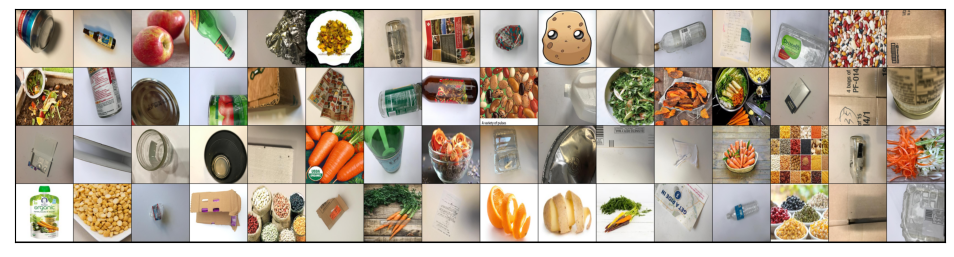

In [17]:
show_batch(train_dl)

In [31]:
for X, y in test_dl:
    print(f"shape of X [N, C H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

shape of X [N, C H, W]: torch.Size([128, 3, 256, 256])
Shape of y: torch.Size([128]) torch.int64


In [18]:
import torch.nn.functional as F

In [20]:
import torchvision.models as models

In [32]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

# Define Model
class NeuralNetwork(nn.Module):
    # define layers of the network
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [33]:
# Optimizing model parameters
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")

In [34]:
# check model's performance
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100 * correct) :> 0.1f}%, Avg loss: {test_loss:>8f} \n")
    

In [35]:
epochs = 5
for t in range(epochs):
    print(f"epoch {t+1}\n----------------")
    train(train_dl, model, loss_fn, optimizer)
    test(test_dl, model, loss_fn)
print("Done!")

epoch 1
----------------


RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x196608 and 784x512)